In [1]:
# Forcing me to access all files relative to the main project folder.

import os
os.chdir("/home/srakrn/Works/senior/project/")
os.getcwd()

'/home/srakrn/Works/senior/project'

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
import pandas as pd
import torch
import torch.nn.functional as F
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

In [4]:
mnist_trainset = datasets.MNIST(
    root="mnist", train=True, download=True, transform=transform
)
mnist_testset = datasets.MNIST(
    root="mnist", train=False, download=True, transform=transform
)

In [5]:
trainloader = DataLoader(mnist_trainset, batch_size=64, shuffle=True)
full_trainloader = DataLoader(mnist_trainset, batch_size=len(mnist_trainset), shuffle=True)
testloader = DataLoader(mnist_testset, batch_size=1, shuffle=False)

In [6]:
class MnistFcnn(nn.Module):
    def __init__(self):
        super(MnistFcnn, self).__init__()
        self.linear1 = nn.Linear(784, 128)
        self.linear2 = nn.Linear(128, 64)
        self.linear3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.reshape(-1, 28 * 28)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [88]:
model = MnistFcnn()
mnist_state = torch.load("models/mnist_fcnn.model")
model.load_state_dict(mnist_state)

<All keys matched successfully>

In [8]:
y_test = []
y_pred = []
for image, label in testloader:
    y_test.append(label.item())
    y_pred.append(model(image).argmax(axis=1).item())

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.98      0.96       980
           1       0.97      0.97      0.97      1135
           2       0.93      0.92      0.93      1032
           3       0.91      0.92      0.91      1010
           4       0.93      0.93      0.93       982
           5       0.91      0.89      0.90       892
           6       0.93      0.95      0.94       958
           7       0.95      0.91      0.93      1028
           8       0.89      0.90      0.89       974
           9       0.92      0.91      0.92      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



In [10]:
trainset_perturbs = torch.load("perturbs/on_single_point/fcnn_trainset_on_single_point.pt")
testset_perturbs = torch.load("perturbs/on_single_point/fcnn_testset_on_single_point.pt")

In [12]:
y_test = []
y_pred = []
for (image, label), perturb in zip(testloader, trainset_perturbs):
    y_test.append(label.item())
    y_pred.append(model(image + 0.2 * perturb.reshape(1, 1, 28, 28)).argmax(axis=1).item())

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       980
           1       0.95      0.47      0.63      1135
           2       0.48      0.83      0.61      1032
           3       0.51      0.74      0.60      1010
           4       0.83      0.63      0.72       982
           5       0.61      0.67      0.64       892
           6       0.85      0.69      0.76       958
           7       0.82      0.67      0.74      1028
           8       0.56      0.66      0.60       974
           9       0.76      0.53      0.62      1009

    accuracy                           0.68     10000
   macro avg       0.72      0.68      0.68     10000
weighted avg       0.73      0.68      0.68     10000



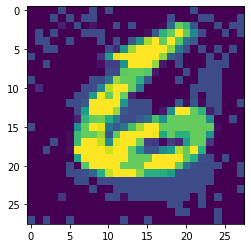

In [13]:
plt.imshow((image + 0.3 * perturb.reshape(1, 1, 28, 28)).reshape(28, 28).detach().numpy())
plt.show()

In [27]:
def calculate_k_perturbs(
    model, training_set, clusterer, k, n_epoches=20, verbose=0, log=False
):
    loader = DataLoader(training_set, batch_size=len(training_set), shuffle=False)
    X, y = next(iter(loader))
    km = KMeans(n_clusters=k, verbose=verbose, n_init=3)
    km_clusters = km.fit_predict(clusterer.reshape(len(clusterer), -1))
    print(f"Training {k} perturbs")

    k_points = []
    k_perturbs = []
    losses = []

    for i in set(km_clusters):
        if log:
            log_f = open(log, "a")
        idx = np.where(km_clusters == i)[0]
        data = [training_set[j] for j in idx]
        trainloader = DataLoader(data, batch_size=len(data), shuffle=False)

        perturb = torch.zeros([1, 28 * 28], requires_grad=True)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adagrad([perturb], lr=0.03)

        if verbose:
            print(f"Training #{i+1} perturb")
            print(f"\tThis set of perturbation will attack {len(data)} data points.")

        for e in range(n_epoches):
            running_loss = 0
            for images, labels in trainloader:
                images = images.reshape(-1, 28 * 28)
                optimizer.zero_grad()
                output = model(images + perturb)
                loss = -1 * criterion(output, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                perturb.data.clamp(-1, 1)
        if verbose:
            print(f"\tTraining loss: {-1 * running_loss/len(trainloader)}")
        losses.append(-1 * running_loss / len(trainloader))
        k_points.append(idx)
        k_perturbs.append(perturb.detach().numpy())
    if log:
        t = time.strftime("%H:%M:%S", time.localtime())
        log_f.write(f"{t},{k},")
        log_f.write(",".join([f"{i:.5f}" for i in losses]))
        log_f.write("\n")
    return [k_points, k_perturbs, km]

In [32]:
train_target, train_perturb, train_km = calculate_k_perturbs(
    model, mnist_trainset, trainset_perturbs.detach().numpy(), 100, verbose=2
)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 4406033.5
start iteration
done sorting
end inner loop
Iteration 1, inertia 4347936.0
start iteration
done sorting
end inner loop
Iteration 2, inertia 4331541.5
start iteration
done sorting
end inner loop
Iteration 3, inertia 4325271.0
start iteration
done sorting
end inner loop
Iteration 4, inertia 4322342.5
start iteration
done sorting
end inner loop
Iteration 5, inertia 4320520.5
start iteration
done sorting
end inner loop
Iteration 6, inertia 4319275.0
start iteration
done sorting
end inner loop
Iteration 7, inertia 4318274.5
start iteration
done sorting
end inner loop
Iteration 8, inertia 4317538.0
start iteration
done sorting
end inner loop
Iteration 9, inertia 4317034.5
start iteration
done sorting
end inner loop
Iteration 10, inertia 4316464.0
start iteration
done sorting
end inner loop
Iteration 11, inertia 4315482.0
start iteration
done sorting
end inner loop
Iteration 12, inertia 4314663.

Iteration 17, inertia 4326564.0
start iteration
done sorting
end inner loop
Iteration 18, inertia 4326555.0
start iteration
done sorting
end inner loop
Iteration 19, inertia 4326552.5
start iteration
done sorting
end inner loop
Iteration 20, inertia 4326547.0
start iteration
done sorting
end inner loop
Iteration 21, inertia 4326550.0
start iteration
done sorting
end inner loop
Iteration 22, inertia 4326548.0
start iteration
done sorting
end inner loop
Iteration 23, inertia 4326548.0
center shift 0.000000e+00 within tolerance 7.956775e-05
Training 100 perturbs
Training #1 perturb
	This set of perturbation will attack 804 data points.
	Training loss: 13.61217975616455
Training #2 perturb
	This set of perturbation will attack 2178 data points.
	Training loss: 12.957147598266602
Training #3 perturb
	This set of perturbation will attack 1764 data points.
	Training loss: 7.527134418487549
Training #4 perturb
	This set of perturbation will attack 802 data points.
	Training loss: 7.31020355224

Training #71 perturb
	This set of perturbation will attack 1427 data points.
	Training loss: 11.133417129516602
Training #72 perturb
	This set of perturbation will attack 196 data points.
	Training loss: 10.727771759033203
Training #73 perturb
	This set of perturbation will attack 351 data points.
	Training loss: 12.477163314819336
Training #74 perturb
	This set of perturbation will attack 627 data points.
	Training loss: 14.163546562194824
Training #75 perturb
	This set of perturbation will attack 247 data points.
	Training loss: 14.601034164428711
Training #76 perturb
	This set of perturbation will attack 247 data points.
	Training loss: 12.155169486999512
Training #77 perturb
	This set of perturbation will attack 128 data points.
	Training loss: 13.708849906921387
Training #78 perturb
	This set of perturbation will attack 119 data points.
	Training loss: 7.047152042388916
Training #79 perturb
	This set of perturbation will attack 397 data points.
	Training loss: 12.073348999023438
T

In [33]:
test_target, test_perturb, test_km = calculate_k_perturbs(
    model, mnist_testset, testset_perturbs.detach().numpy(), 100, verbose=2
)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 267798.94
start iteration
done sorting
end inner loop
Iteration 1, inertia 256381.22
start iteration
done sorting
end inner loop
Iteration 2, inertia 254762.98
start iteration
done sorting
end inner loop
Iteration 3, inertia 253741.02
start iteration
done sorting
end inner loop
Iteration 4, inertia 253248.75
start iteration
done sorting
end inner loop
Iteration 5, inertia 252976.52
start iteration
done sorting
end inner loop
Iteration 6, inertia 252845.53
start iteration
done sorting
end inner loop
Iteration 7, inertia 252749.81
start iteration
done sorting
end inner loop
Iteration 8, inertia 252721.19
start iteration
done sorting
end inner loop
Iteration 9, inertia 252709.44
start iteration
done sorting
end inner loop
Iteration 10, inertia 252702.44
start iteration
done sorting
end inner loop
Iteration 11, inertia 252700.11
start iteration
done sorting
end inner loop
Iteration 12, inertia 252700.1

	Training loss: 11.82180404663086
Training #39 perturb
	This set of perturbation will attack 40 data points.
	Training loss: 9.36093521118164
Training #40 perturb
	This set of perturbation will attack 64 data points.
	Training loss: 10.276178359985352
Training #41 perturb
	This set of perturbation will attack 65 data points.
	Training loss: 8.356453895568848
Training #42 perturb
	This set of perturbation will attack 38 data points.
	Training loss: 11.292190551757812
Training #43 perturb
	This set of perturbation will attack 55 data points.
	Training loss: 10.83713150024414
Training #44 perturb
	This set of perturbation will attack 63 data points.
	Training loss: 12.086762428283691
Training #45 perturb
	This set of perturbation will attack 57 data points.
	Training loss: 10.285807609558105
Training #46 perturb
	This set of perturbation will attack 41 data points.
	Training loss: 9.548905372619629
Training #47 perturb
	This set of perturbation will attack 104 data points.
	Training loss:

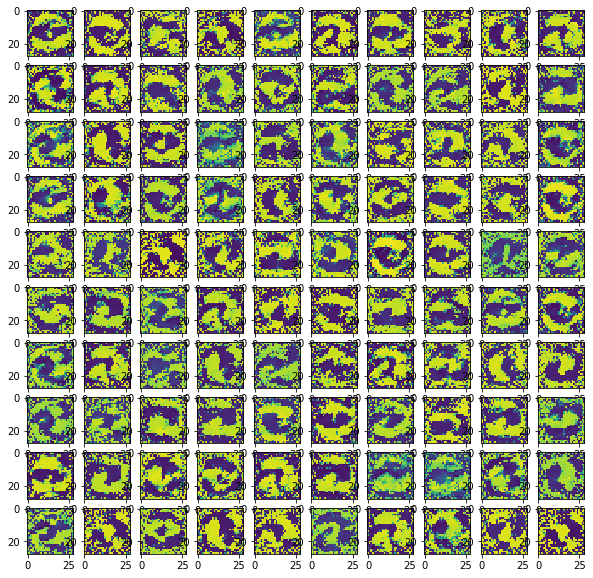

In [36]:
fig, axs = plt.subplots(10, 10, figsize=(10, 10))
for ax, perturb in zip(axs.ravel(), train_perturb):
    ax.imshow(perturb.reshape(28, 28))
plt.show()

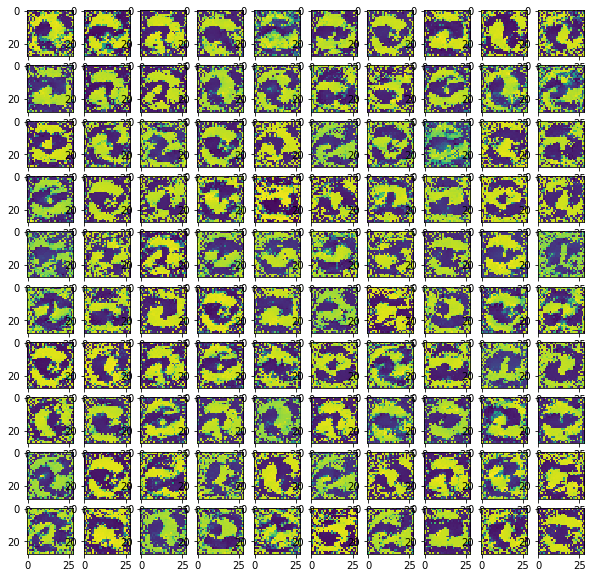

In [37]:
fig, axs = plt.subplots(10, 10, figsize=(10, 10))
for ax, perturb in zip(axs.ravel(), test_perturb):
    ax.imshow(perturb.reshape(28, 28))
plt.show()

In [43]:
def get_nth_perturb(n, targets, perturbs):
    for i, j in zip(targets, perturbs):
        if i in targets:
            return j
    return None

In [47]:
y_test = []
y_pred = []
for i, (image, label) in enumerate(testloader):
    y_test.append(label.item())
    perturb = torch.tensor(get_nth_perturb(i, test_target, test_perturb))
    y_pred.append(model(image + 0.2 * perturb.reshape(1, 1, 28, 28)).argmax(axis=1).item())

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       980
           1       0.93      0.98      0.95      1135
           2       0.67      0.96      0.79      1032
           3       0.55      0.96      0.69      1010
           4       0.97      0.79      0.87       982
           5       0.97      0.49      0.65       892
           6       0.96      0.88      0.92       958
           7       0.74      0.94      0.83      1028
           8       0.97      0.46      0.62       974
           9       0.94      0.62      0.75      1009

    accuracy                           0.81     10000
   macro avg       0.86      0.80      0.80     10000
weighted avg       0.86      0.81      0.81     10000



In [69]:
class PerturbDataset(Dataset):
    def __init__(self, data, targets, perturbs, density = 0.2):
        super().__init__()
        self.data = data
        self.targets = targets
        self.perturbs = perturbs
        self.density = density
    def __len__(self):
        return len(self.data)
    def _get_nth_perturb(self, n):
        for i, j in zip(self.targets, self.perturbs):
            if i in self.targets:
                return j
        return None
    def __getitem__(self, idx):
        X, y  = self.data[idx]
        X += 0.2 * perturb.reshape(1, 28, 28)
        return X, y

In [70]:
pd = PerturbDataset(mnist_trainset, train_target, train_perturb)

In [71]:
perturbloader = DataLoader(pd, batch_size=16, shuffle=True)

In [89]:
criterion = nn.CrossEntropyLoss(reduction='none')
optimizer = optim.Adam(model.parameters())
epochs = 10
for e in range(epochs):
    running_loss = 0
    for (images, labels), (adver_images, adver_labels) in zip(trainloader, perturbloader):
        X = torch.cat([images, adver_images], 0)
        y = torch.cat([labels, adver_labels], 0)
        w = torch.tensor([1 if i < len(labels) else 2 for i in range(len(labels) + len(adver_labels))]).float()
        optimizer.zero_grad()

        output = F.log_softmax(model(X), dim=1)
        loss = torch.dot(criterion(output, y), w)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 21.95227226570471
Training loss: 12.573753699819163
Training loss: 10.035969775432209
Training loss: 7.660819547199237
Training loss: 6.6649539424920645
Training loss: 6.151157568353834
Training loss: 5.67292042673905
Training loss: 5.1222133751807695
Training loss: 4.516937492403394
Training loss: 4.334715902090454


In [91]:
y_test = []
y_pred = []
for image, label in testloader:
    y_test.append(label.item())
    y_pred.append(model(image).argmax(axis=1).item())

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.99      0.98      1032
           3       0.97      0.97      0.97      1010
           4       0.98      0.98      0.98       982
           5       0.97      0.98      0.97       892
           6       0.97      0.99      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.99      0.96      0.97       974
           9       0.98      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [90]:
y_test = []
y_pred = []
for (image, label), perturb in zip(testloader, trainset_perturbs):
    y_test.append(label.item())
    y_pred.append(model(image + 0.2 * perturb.reshape(1, 1, 28, 28)).argmax(axis=1).item())

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       980
           1       0.99      0.86      0.92      1135
           2       0.83      0.97      0.90      1032
           3       0.91      0.92      0.91      1010
           4       0.94      0.93      0.93       982
           5       0.90      0.96      0.93       892
           6       0.89      0.97      0.93       958
           7       0.96      0.86      0.91      1028
           8       0.82      0.89      0.86       974
           9       0.94      0.80      0.86      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.92      0.91      0.91     10000



In [92]:
rem = MnistFcnn()

In [93]:
criterion = nn.CrossEntropyLoss(reduction='none')
optimizer = optim.Adam(rem.parameters())
epochs = 10
for e in range(epochs):
    running_loss = 0
    for (images, labels), (adver_images, adver_labels) in zip(trainloader, perturbloader):
        X = torch.cat([images, adver_images], 0)
        y = torch.cat([labels, adver_labels], 0)
        w = torch.tensor([1 if i < len(labels) else 2 for i in range(len(labels) + len(adver_labels))]).float()
        optimizer.zero_grad()

        output = F.log_softmax(rem(X), dim=1)
        loss = torch.dot(criterion(output, y), w)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 36.7224055922616
Training loss: 17.125758046026167
Training loss: 12.336657520169133
Training loss: 9.651855384108863
Training loss: 8.081359548037494
Training loss: 7.131657051442783
Training loss: 5.983942917256213
Training loss: 5.576184453438721
Training loss: 4.932161580064276
Training loss: 4.71790798427835


In [94]:
y_test = []
y_pred = []
for image, label in testloader:
    y_test.append(label.item())
    y_pred.append(model(image).argmax(axis=1).item())

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.99      0.98      1032
           3       0.97      0.97      0.97      1010
           4       0.98      0.98      0.98       982
           5       0.97      0.98      0.97       892
           6       0.97      0.99      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.99      0.96      0.97       974
           9       0.98      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [95]:
y_test = []
y_pred = []
for (image, label), perturb in zip(testloader, trainset_perturbs):
    y_test.append(label.item())
    y_pred.append(model(image + 0.2 * perturb.reshape(1, 1, 28, 28)).argmax(axis=1).item())

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       980
           1       0.99      0.86      0.92      1135
           2       0.83      0.97      0.90      1032
           3       0.91      0.92      0.91      1010
           4       0.94      0.93      0.93       982
           5       0.90      0.96      0.93       892
           6       0.89      0.97      0.93       958
           7       0.96      0.86      0.91      1028
           8       0.82      0.89      0.86       974
           9       0.94      0.80      0.86      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.92      0.91      0.91     10000

